# Let's Grow your Own Inner Core!

### Choose a model in the list: 
    - geodyn_trg.PureTranslation()
    - geodyn_trg.TranslationRotation()
    - geodyn_trg.PureGrowth()
    - geodyn_trg.TranslationGrowth()
    - geodyn_trg.TranslationGrowthRotation()
    - geodyn_static.Hemispheres()

### Choose a proxy type:
    - age
    - position (! will give a Point instance)
    - phi
    - theta
    - growth rate

### set the parameters for the model : geodynModel.set_parameters(parameters)
### set the units : geodynModel.define_units()

### Choose a data set:
    - data.SeismicFromFile(filename) # Lauren's data set
    - data.RandomData(numbers_of_points)
    - data.PerfectSamplingEquator(numbers_of_points)
        organized on a cartesian grid. numbers_of_points is the number of points along the x or y axis. The total number of points is numbers_of_points**2*pi/4
        - as a special plot function to show streamlines: plot_c_vec(self,modelgeodyn)
    - data.PerfectSamplingEquatorRadial(Nr, Ntheta)
        same than below, but organized on a polar grid, not a cartesian grid.


### Extract the info:
    - calculate the proxy value for all points of the data set: geodyn.evaluate_proxy(data_set, geodynModel)
    - extract the positions as numpy arrays: extract_rtp or extract_xyz
    - calculate other variables: positions.angular_distance_to_point(t,p, t_point, p_point)

In [1]:
%matplotlib inline

# import statements
import numpy as np
import matplotlib.pyplot as plt #for figures
from mpl_toolkits.basemap import Basemap #to render maps
import math

import positions
import geodyn, geodyn_trg, geodyn_static
import plot_data
import data

plt.rcParams['figure.figsize'] = (15.0, 5.0) #size of figures

1.5.2


## Define the geodynamical model

In [2]:
## un-comment one of them
# geodynModel = geodyn_trg.PureTranslation() #in this case, the translation velocity has to be larger than 2 (if not, ages would be negatives)
# geodynModel = geodyn_trg.TranslationRotation()
# geodynModel = geodyn_trg.PureGrowth()
# geodynModel = geodyn_trg.TranslationGrowth()
geodynModel = geodyn_trg.TranslationGrowthRotation()
# geodynModel = geodyn_static.Hemispheres() #this is a static model, only hemispheres. 

### Parameters for the geodynamical model

In [3]:
units = None #first, we start with dimensionless parameters 
rICB = 1.
age_ic = 1.
omega = -0.5*np.pi # Rotation rates has to be in ]-np.pi, np.pi[
velocity_amplitude = 0.8
velocity_center = [0., 100.]#center of the eastern hemisphere
velocity = geodyn_trg.translation_velocity(velocity_center, velocity_amplitude)
proxy_type = "age"

In [4]:
parameters = {'units': units,
              'rICB': rICB, 
              'tau_ic':age_ic,
              'vt': velocity,
              'exponent_growth': 0.5,
              'omega': omega,
              'proxy_type': proxy_type}
geodynModel.set_parameters(parameters)
geodynModel.define_units()

## Different data set and visualisations

### Perfect sampling at the equator (to visualise the flow lines)

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is age
= Data set is Perfect sampling in the equatorial plane
= Proxy is evaluated for bt_point
= Number of points to examine: 1876
===


/usr/local/lib/python2.7/site-packages/scipy/integrate/_ode.py:1018: UserWarning: dopri5: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


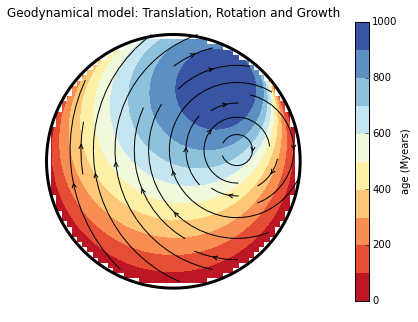

In [5]:
npoints = 50 #number of points in the x direction for the data set. 
data_set = data.PerfectSamplingEquator(npoints, rICB = 1.)
data_set.method = "bt_point"
proxy = geodyn.evaluate_proxy(data_set, geodynModel, proxy="age", verbose = False)
data_set.plot_c_vec(geodynModel, proxy=proxy, cm=plt.cm.get_cmap('RdYlBu'), nameproxy="age (Myears)")

### Random data set, with "realistic" repartition

In [6]:
# random data set
data_set_random = data.RandomData(3000)
data_set_random.method = "bt_point"

proxy_random = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy="age", verbose=False)
r, t, p = data_set_random.extract_rtp("bottom_turning_point")
dist = positions.angular_distance_to_point(t, p, *velocity_center)

#data_set_random.map_plot(geodynModel.name)
#data_set_random.phi_plot(geodynModel.name)
#data_set_random.distance_plot(geodynModel.name, positions.SeismoPoint(1., 0., -80.)) 

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is age
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000
===


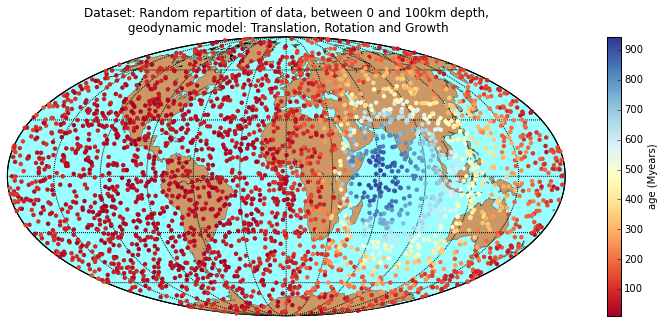

In [7]:
## map
m, fig = plot_data.setting_map() 
cm = plt.cm.get_cmap('RdYlBu')
x, y = m(p, t)
sc = m.scatter(x, y, c=proxy_random, zorder=10, cmap=cm, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label("age (Myears)")

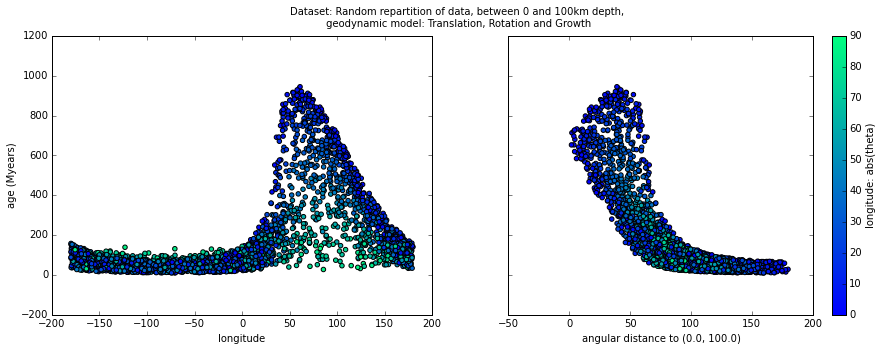

In [8]:
## phi and distance plots
fig, ax = plt.subplots(1,2, sharey=True)
cm2 = plt.cm.get_cmap('winter')
sc1 = ax[0].scatter(p, proxy_random, c=abs(t), cmap=cm2, vmin =-0, vmax =90)
ax[0].set_xlabel("longitude")
ax[0].set_ylabel("age (Myears)")
sc2 = ax[1].scatter(dist, proxy_random, c=abs(t), cmap=cm2, vmin=-0, vmax =90)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = fig.colorbar(sc2)
cbar.set_label("longitude: abs(theta)")

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is domain_size
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000
===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is dV_V
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000
===


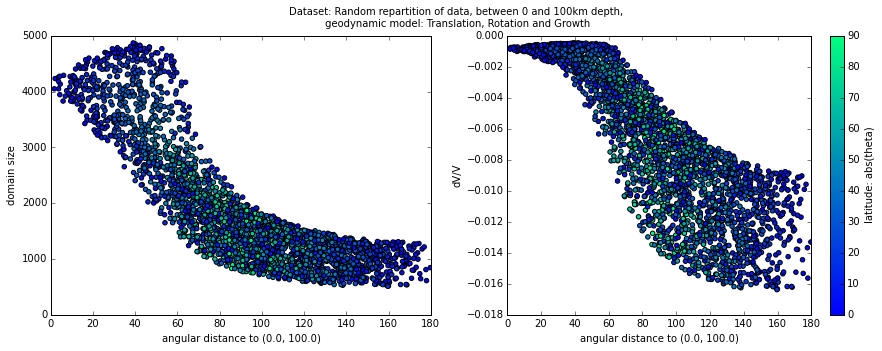

In [9]:
geodynModel.proxy_type = "domain_size"
proxy_random_size = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy="domain_size", verbose=False)
geodynModel.proxy_type = "dV_V"
proxy_random_dV = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy="dV_V", verbose=False)

## phi and distance plots
fig, ax = plt.subplots(1,2)
cm2 = plt.cm.get_cmap('winter')
sc1 = ax[0].scatter(dist, proxy_random_size, c=abs(t), cmap=cm2, vmin =-0, vmax =90)
ax[0].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[0].set_ylabel("domain size")
ax[0].set_xlim([0,180])
ax[0].set_ylim([0, 5000.000])
sc2 = ax[1].scatter(dist, proxy_random_dV, c=abs(t), cmap=cm2, vmin=-0, vmax =90)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[1].set_ylabel("dV/V")
ax[1].set_xlim([0,180])
ax[1].set_ylim([-0.018, 0.000])
fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = fig.colorbar(sc2)
cbar.set_label("latitude: abs(theta)")


### Real Data set from Waszek paper

In [10]:
## real data set
data_set2 = data.SeismicFromFile("results.dat")
data_set2.method = "bt_point"
geodynModel.proxy_type = "age"
proxy2 = geodyn.evaluate_proxy(data_set2, geodynModel, proxy="age", verbose=False)

r, t, p = data_set2.extract_rtp("bottom_turning_point")
dist = positions.angular_distance_to_point(t, p, *velocity_center)

#data_set2.proxy = proxy2 #evaluate_proxy(data_set, geodynModel)
#data_set2.map_plot(geodynModel.name)
#data_set2.phi_plot(geodynModel.name)
#data_set2.distance_plot(geodynModel.name, positions.SeismoPoint(1., 0., -80.))

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is age
= Data set is Data set from Lauren's file
= Proxy is evaluated for bt_point
= Number of points to examine: 3184
===


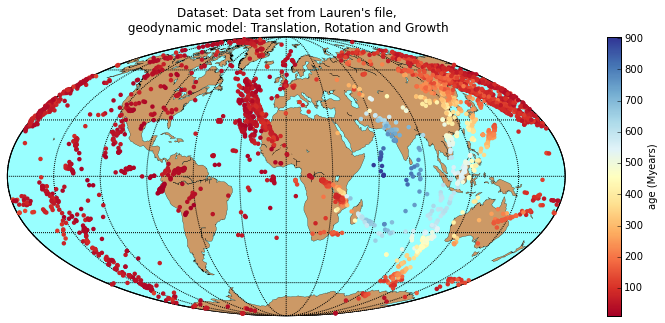

In [11]:
## map
m, fig = plot_data.setting_map() 
cm = plt.cm.get_cmap('RdYlBu')
x, y = m(p, t)
sc = m.scatter(x, y, c=proxy2, zorder=10, cmap=cm, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set2.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label("age (Myears)")

The spatial repartition of real data is sparse because of the repartition of earthquakes and seismic stations over the globe. Here is another way to visualise this fact. Large clusters of observations are concentrated in the north hemisphere, while the south hemisphere has a even more sparse coverage. South hemisphere around latitude 0 has almost no coverage. 

[-180, 180, -90, 90]

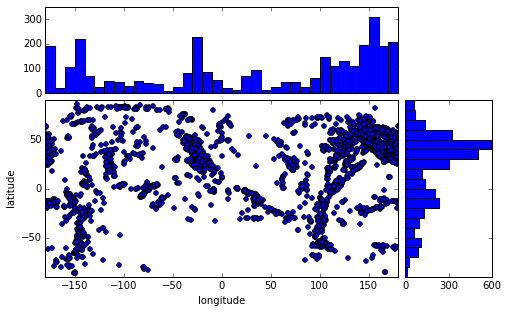

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(p,t)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")


#to add histograms to see the actual repartition. Please see http://matplotlib.org/examples/axes_grid/scatter_hist.html
divider = make_axes_locatable(ax)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),
         visible=False)
binwidth = 10.
limX = (int(180./binwidth) + 1)*binwidth
limY = (int(90./binwidth) + 1)*binwidth
binsX = np.arange(-limX, limX + binwidth, binwidth)
binsY = np.arange(-limY, limY + binwidth, binwidth)
axHistx.hist(p, bins=binsX)
axHisty.hist(t, bins=binsY, orientation='horizontal')
#axHistx.axis["bottom"].major_ticklabels.set_visible(False)
for tl in axHistx.get_xticklabels():
    tl.set_visible(False)
axHistx.set_yticks([0, 100, 200, 300])
#axHisty.axis["left"].major_ticklabels.set_visible(False)
for tl in axHisty.get_yticklabels():
    tl.set_visible(False)
axHisty.set_xticks([0, 300, 600])
ax.set_aspect('equal')
ax.axis([-180, 180, -90, 90])

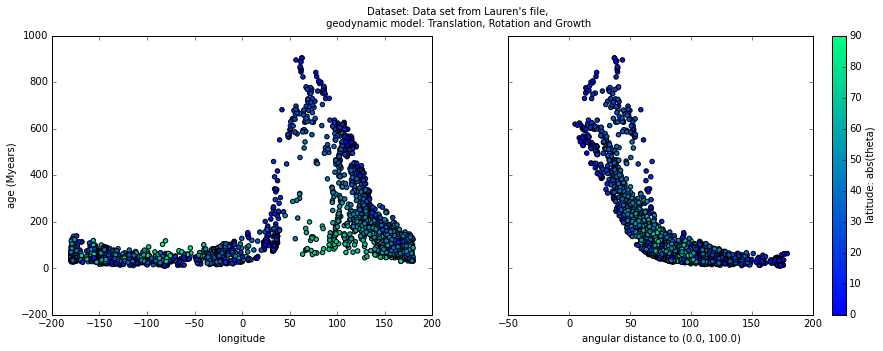

In [13]:
fig, ax = plt.subplots(1,2, sharey=True)
cm2 = plt.cm.get_cmap('winter')
sc1 = ax[0].scatter(p, proxy2, c=abs(t), cmap=cm2, vmin =-0, vmax =90)
ax[0].set_xlabel("longitude")
ax[0].set_ylabel("age (Myears)")
sc2 = ax[1].scatter(dist, proxy2, c=abs(t), cmap=cm2, vmin=-0, vmax =90)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set2.name, geodynModel.name))
cbar = fig.colorbar(sc2)
cbar.set_label("latitude: abs(theta)")

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is domain size
= Data set is Data set from Lauren's file
= Proxy is evaluated for bt_point
= Number of points to examine: 3184
===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is dV_V
= Data set is Data set from Lauren's file
= Proxy is evaluated for bt_point
= Number of points to examine: 3184
===


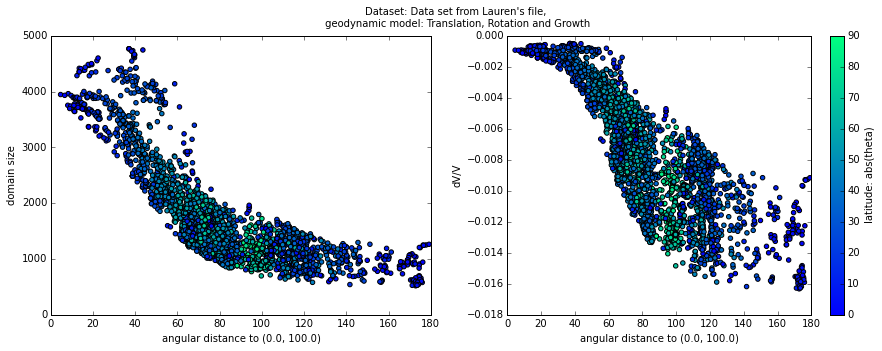

In [14]:
geodynModel.proxy_type = "domain_size"
proxy2_size = geodyn.evaluate_proxy(data_set2, geodynModel, proxy="domain size", verbose=False)
geodynModel.proxy_type = "dV_V"
proxy2_dV = geodyn.evaluate_proxy(data_set2, geodynModel, proxy="dV_V", verbose=False)

## phi and distance plots
fig, ax = plt.subplots(1,2)
cm2 = plt.cm.get_cmap('winter')
sc1 = ax[0].scatter(dist, proxy2_size, c=abs(t), cmap=cm2, vmin =-0, vmax =90)
ax[0].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[0].set_ylabel("domain size")
ax[0].set_xlim([0,180])
ax[0].set_ylim([0, 5000.000])
sc2 = ax[1].scatter(dist, proxy2_dV, c=abs(t), cmap=cm2, vmin=-0, vmax =90)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[1].set_ylabel("dV/V")
ax[1].set_xlim([0,180])
ax[1].set_ylim([-0.018, 0.000])
fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set2.name, geodynModel.name))
cbar = fig.colorbar(sc2)
cbar.set_label("latitude: abs(theta)")

#### What if we vary the position of the reference point?

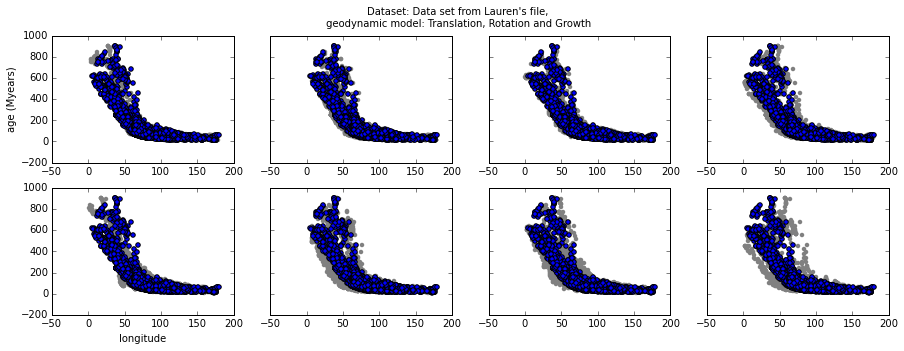

In [15]:
fig, ax = plt.subplots(2, 4, sharey=True)

dist1 = positions.angular_distance_to_point(t, p, 0, 90)
dist2 = positions.angular_distance_to_point(t, p, 10, 100)
dist3 = positions.angular_distance_to_point(t, p, -10, 100)
dist4 = positions.angular_distance_to_point(t, p, 0, 110)
dist11 = positions.angular_distance_to_point(t, p, 0, 80)
dist12 = positions.angular_distance_to_point(t, p, 20, 100)
dist13 = positions.angular_distance_to_point(t, p, -20, 100)
dist14 = positions.angular_distance_to_point(t, p, 0, 120)

sc1 = ax[0,0].scatter(dist1, proxy2, c="grey", lw=0)
sc2 = ax[0,0].scatter(dist, proxy2, c="b")
sc1 = ax[0,1].scatter(dist2, proxy2, c="grey", lw=0)
sc2 = ax[0,1].scatter(dist, proxy2, c="b")
sc1 = ax[0,2].scatter(dist3, proxy2, c="grey", lw=0)
sc2 = ax[0,2].scatter(dist, proxy2, c="b")
sc1 = ax[0,3].scatter(dist4, proxy2, c="grey", lw=0)
sc2 = ax[0,3].scatter(dist, proxy2, c="b")
sc1 = ax[1,0].scatter(dist11, proxy2, c="grey", lw=0)
sc2 = ax[1,0].scatter(dist, proxy2, c="b")
ax[1,0].set_xlabel("longitude")
ax[0,0].set_ylabel("age (Myears)")
sc1 = ax[1,1].scatter(dist12, proxy2, c="grey", lw=0)
sc2 = ax[1,1].scatter(dist, proxy2, c="b")
sc1 = ax[1,2].scatter(dist13, proxy2, c="grey", lw=0)
sc2 = ax[1,2].scatter(dist, proxy2, c="b")
sc1 = ax[1,3].scatter(dist14, proxy2, c="grey", lw=0)
sc2 = ax[1,3].scatter(dist, proxy2, c="b")
fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set2.name, geodynModel.name))


#### Real residuals

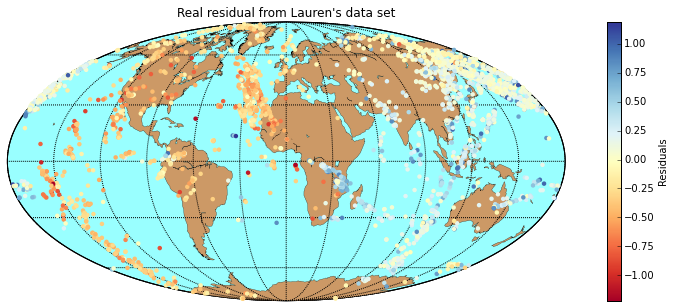

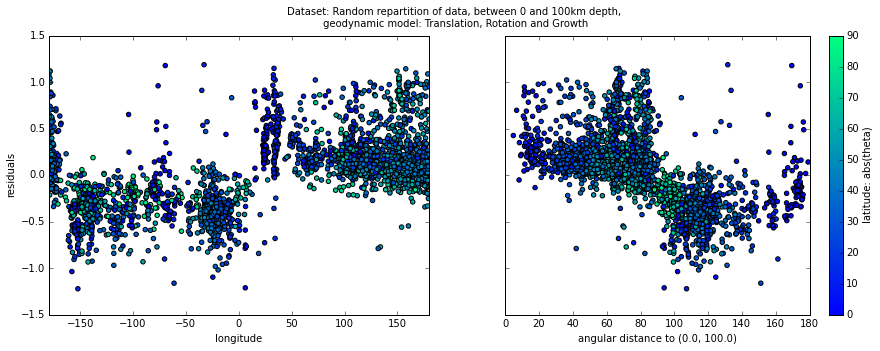

In [16]:
residual = data_set2.real_residual()
## map
m, fig = plot_data.setting_map() 
cm = plt.cm.get_cmap('RdYlBu')
x, y = m(p, t)
sc = m.scatter(x, y, c=residual, zorder=10, cmap=cm, edgecolors='none')
plt.title("Real residual from Lauren's data set")
cbar1 = plt.colorbar(sc)
cbar1.set_label("Residuals")
## phi and distance plots
fig, ax = plt.subplots(1,2, sharey=True)
cm2 = plt.cm.get_cmap('winter')
sc1 = ax[0].scatter(p, residual, c=abs(t), cmap=cm2, vmin =-0, vmax =90)
ax[0].set_xlabel("longitude")
ax[0].set_ylabel("residuals")
ax[0].set_xlim([-180, 180])
sc2 = ax[1].scatter(dist, residual, c=abs(t), cmap=cm2, vmin=-0, vmax =90)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[1].set_xlim([0, 180])
fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar2 = fig.colorbar(sc2)
cbar2.set_label("latitude: abs(theta)")

### Real data set from Waszek paper, but average over raypath

In [17]:
   ## real data set, average over raypath
data_set3 = data.SeismicFromFile("results.dat")
data_set3.method = "raypath"
geodynModel.proxy_type = "age"
geodynModel.evaluation= "0"
data_set3.NpointsRaypath = 20 
proxy3 = geodyn.evaluate_proxy(data_set3, geodynModel, proxy="age", verbose=False)
#data_set3.proxy = proxy3 #evaluate_proxy(data_set, geodynModel)
#data_set3.map_plot(geodynModel.name)
#data_set3.phi_plot(geodynModel.name)
#data_set3.distance_plot(geodynModel.name, positions.SeismoPoint(1., 0., -80.))

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is age
= Data set is Data set from Lauren's file
= Proxy is evaluated for raypath
=== Raypath is 20 number of points
= Number of points to examine: 3184
===


And in the figures:

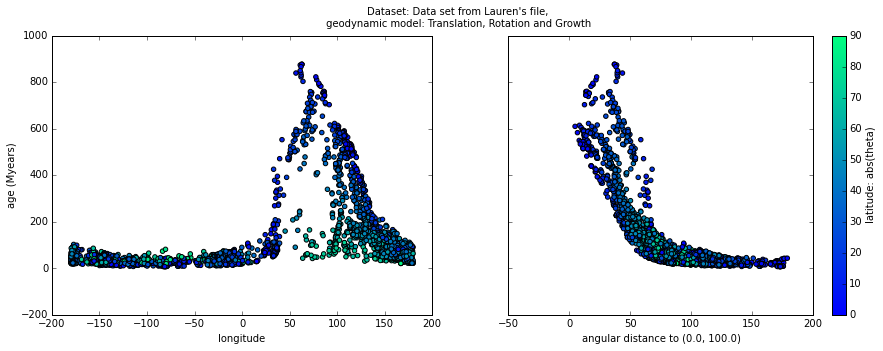

In [18]:
fig, ax = plt.subplots(1,2, sharey=True)
cm2 = plt.cm.get_cmap('winter')
sc1 = ax[0].scatter(p, proxy3, c=abs(t), cmap=cm2, vmin =-0, vmax =90)
ax[0].set_xlabel("longitude")
ax[0].set_ylabel("age (Myears)")
sc2 = ax[1].scatter(dist, proxy3, c=abs(t), cmap=cm2, vmin=-0, vmax =90)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set2.name, geodynModel.name))
cbar = fig.colorbar(sc2)
cbar.set_label("latitude: abs(theta)")